# Attempts to Classify Basketball Player Positions based on Player Data and Season Stats

In [94]:
import os
os.environ['KAGGLE_USERNAME'] = "birjupatel1"
os.environ['KAGGLE_KEY'] = "638f33e93ad4204abf521595a2b1ba04"

In [95]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kaggle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [96]:
# Get Dataset
kaggle.api.authenticate()
kaggle.api.dataset_download_files("drgilermo/nba-players-stats", path="./data/", unzip=True)
player_data = pd.read_csv("./data/player_data.csv")
season_data = pd.read_csv("./data/Seasons_Stats.csv")

Dataset URL: https://www.kaggle.com/datasets/drgilermo/nba-players-stats


## Based on Player Data

In [97]:
player_data.head()

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University


In [98]:
player_data.shape

(4550, 8)

In [99]:
print(f"Players with NAN for height {player_data['height'].isnull().sum()}")
print(f"Players with NAN for weight {player_data['weight'].isnull().sum()}")

Players with NAN for height 1
Players with NAN for weight 6


Since there are only 7 entries with NANs, we will disregard them.

In [100]:
player_data.dropna(inplace=True)

Also, since most classifiers like their input features to be nice and numerical, we will modify the `height` attribute to be in inches (currently in `ft-in` form).

In [101]:
def height_to_inches(height):
    feet, inches = map(int, height.split("-"))
    return feet * 12 + inches


# Apply the function to the DataFrame
player_data["height_inches"] = player_data["height"].apply(height_to_inches)
player_data.head(1)

,name,year_start,year_end,position,height,weight,birth_date,college,height_inches
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University,82


As a start, let's just use height and weight to predict player position.

In [102]:
X = player_data[["weight", "height_inches"]]
y = player_data["position"]
le = LabelEncoder()
y = le.fit_transform(y)  # Encode categorical variables into numerical labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

We begin by using a Random Forest Classifier

In [103]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [104]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 59.19335705812574%


---

## Based on Season Stats

In [105]:
season_data.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


Note that this value has many `NaN`s (null values), especially from older data. So we need to do pre-processing to remove those entries.

In [106]:
# Clean Data by dropping columns with all NaN values
season_data.drop(['Unnamed: 0', 'blanl', 'blank2'], axis=1, inplace=True, errors="ignore")

# Add height and weight to players
season_data['height_inches'] = np.nan
season_data['weight'] = np.nan
for index, row in player_data.iterrows():
    season_data.loc[season_data['Player'] == row['name'], 'height_inches'] = row['height_inches']
    season_data.loc[season_data['Player'] == row['name'], 'weight'] = row['weight']

# Drop records with missing data
season_data.dropna(inplace=True)

# Also dropping the name of the player...hopefully players aren't assigned positions based on their names
# Also dropping the year since we are not predicting the position of a player in a specific year
season_data.drop(['Year', 'Player'], axis=1, inplace=True, errors="ignore")
season_data.head(5)

,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height_inches,weight
5781,SF,29.0,BOS,82.0,7.0,1994.0,14.6,0.526,0.054,0.316,...,224.0,330.0,156.0,120.0,36.0,143.0,214.0,914.0,78.0,205.0
5786,SG,33.0,BOS,60.0,0.0,523.0,7.8,0.402,0.032,0.222,...,42.0,73.0,38.0,31.0,11.0,33.0,80.0,167.0,77.0,210.0
5835,SG,31.0,BOS,73.0,73.0,2115.0,13.0,0.537,0.231,0.161,...,104.0,181.0,215.0,111.0,27.0,105.0,178.0,816.0,77.0,190.0
5867,PG,24.0,BOS,76.0,2.0,1061.0,12.7,0.539,0.016,0.338,...,46.0,83.0,147.0,45.0,15.0,109.0,96.0,473.0,77.0,215.0
5901,SF,23.0,BOS,65.0,0.0,674.0,14.1,0.567,0.098,0.275,...,34.0,66.0,47.0,29.0,5.0,49.0,91.0,351.0,78.0,185.0


## XGBoost

In [107]:
y = season_data['Pos']
y = le.fit_transform(y)
X = season_data.drop('Pos', axis=1)
X['Tm'] = le.fit_transform(X['Tm']) # Encode team names as numerical labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='multi:softmax')
bst.fit(X_train, y_train)
preds = bst.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 46.37910565888405%


**XGBoost is worthless here!**

## Random Forest

In [108]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [109]:
preds = rf.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 77.7601899485556%


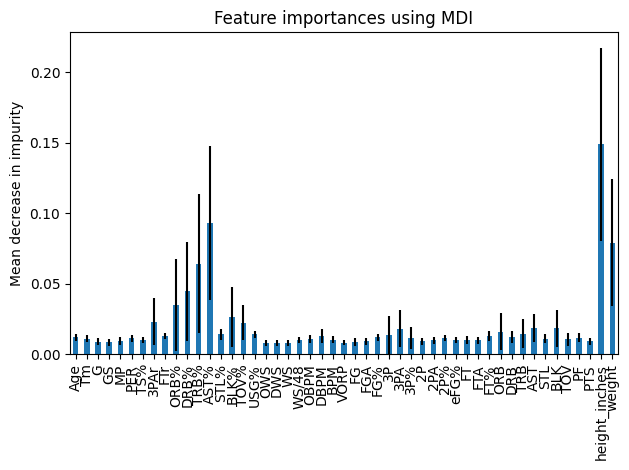

In [110]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=list(X.columns))
fig, ax = plt.subplots()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
forest_importances.plot.bar(yerr=std, ax=ax)
fig.tight_layout()

In [111]:
print(forest_importances.sort_values(ascending=False).head(10))

height_inches    0.148824
AST%             0.093253
weight           0.079037
TRB%             0.064407
DRB%             0.044652
ORB%             0.034954
BLK%             0.026587
3PAr             0.023169
TOV%             0.022574
AST              0.018810
dtype: float64


### RandomForest Round 2: Only with five most important features

In [112]:
y = season_data['Pos']
y = le.fit_transform(y)
X = season_data[['AST%', 'TRB%', 'DRB%', 'ORB%', 'BLK%']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.596359319351009


## Decision Trees


In [113]:
y = season_data['Pos']
y = le.fit_transform(y)
X = season_data.drop('Pos', axis=1)
X['Tm'] = le.fit_transform(X['Tm']) # Encode team names as numerical labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [114]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [115]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6881677878907796


In [116]:
"""
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('dtree.png')
Image(graph.create_png())
"""

"\nfrom sklearn.tree import export_graphviz\nfrom six import StringIO  \nfrom IPython.display import Image  \nimport pydotplus\n\ndot_data = StringIO()\nexport_graphviz(clf, out_file=dot_data,  \n                filled=True, rounded=True,\n                special_characters=True)\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \ngraph.write_png('dtree.png')\nImage(graph.create_png())\n"

In [117]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 2527 points : 997
